In [534]:
import glob
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.io import loadmat
from pingouin import rm_anova
import matplotlib.pyplot as plt

# Model Assignment

In [150]:
files = glob.glob('raw/8/*.mat')

categorizations = {'00': [], '01': [], '10': [], '11': []}

df = 10
n = 18
for f in files:
    subject = f[6:f.find('.')]
    mat = loadmat(f)
    
    n2 = 72
    count_sig_aa = 0
    count_sig_ab = 0
    for i in range(1, 6):
        pAA_dat = mat[f'p_AA_{i}Diff'][0]
        pBB_dat = mat[f'p_BB_{i}Diff'][0]
        pAB_dat = mat[f'p_AB_{i}Diff'][0]
        pBA_dat = mat[f'p_BA_{i}Diff'][0]

        chi_squared = 0
        for pAA, pBB in zip(pAA_dat, pBB_dat):
            p_mean = (pAA+pBB)/2
            if p_mean == 0:
                p_mean += 1/2/n
            elif p_mean == 1:
                p_mean -= 1/2/n
            chi_squared += n*((pAA-p_mean)**2+(pBB-p_mean)**2)/p_mean/(1-p_mean)

        if 1-st.chi2.cdf(chi_squared, df) <= 0.05:
            count_sig_aa+=1

        chi_squared = 0
        for pAB, pBA in zip(pAB_dat, pBA_dat):
            p_mean = (pAB+pBA)/2
            if p_mean == 0:
                p_mean += 1/2/n2
            elif p_mean == 1:
                p_mean -= 1/2/n2
            chi_squared += n*((pAB-p_mean)**2+(pBA-p_mean)**2)/p_mean/(1-p_mean)

        if 1-st.chi2.cdf(chi_squared, df) <= 0.05:
            count_sig_ab+=1

    '''
    if count_sig_aa == 0:
        print('pAA==pBB')
    else:
        print('pAA!=pBB')
    if count_sig_ab == 0:
        print('pAA==pBA')
    else:
        print('pAB!=pBA')
    '''
        
    if count_sig_aa == 0 and count_sig_ab == 0:
        categorizations['11'].append(subject)
    elif count_sig_aa == 0 and count_sig_ab != 0:
        categorizations['10'].append(subject)
    elif count_sig_aa != 0 and count_sig_ab == 0:
        categorizations['01'].append(subject)
    elif count_sig_aa != 0 and count_sig_ab != 0:
        categorizations['00'].append(subject)
        
for category in categorizations.keys():
    print(category)
    print('========')
    print(categorizations[category])
    print()

00
['CP', 'HXT', 'LR', 'ZC', 'ZM', 'ZYC']

01
['HZL', 'LJJ']

10
['CW', 'CY', 'GJ', 'JYN', 'LXL', 'RSL', 'SJ', 'SJ2', 'SXQ', 'SYB', 'WJ', 'WY', 'YJX', 'ZQT', 'ZT']

11
['CSF', 'LT', 'ZBY']



# Plotting model vs. human in p-space

In [ ]:
types = ['AA', 'BB', 'AB', 'BA']
p_data = pd.read_csv('p_data.csv', index_col="Subject")

files = glob.glob('raw/8/*.mat')
ratings_threshold = 1.0

for f in files:
    dat = loadmat(f)
    subject = f[max(f.rfind('/'), f.rfind('\\'))+1:f.find('.')]

    num_ratings = 0
    for i in range(1, 6):
        if p_data.loc[subject][f'PF{i}'] <= ratings_threshold:
            num_ratings += 1
            
    points = []
    for t in types:
        points.append(np.concatenate([dat[f'p_{t}_{n+1}Diff'][0] for n in range(num_ratings)]))
    points = np.array(points).T

    model_pts = pd.read_csv(f'models/{subject}_points.csv', index_col=0)
    model_pts = [model_pts.iloc[p].tolist() for p in range(len(model_pts))]

    plt.clf()
    pF, pH = zip(*[((pAA+pBB)/2, (pAB+pBA)/2) for pAA, pBB, pAB, pBA in points])
    plt.scatter(pF, pH, marker='^', c='blue', label='Subject')
    pF, pH = zip(*[((pAA+pBB)/2, (pAB+pBA)/2) for pAA, pBB, pAB, pBA in model_pts])
    plt.scatter(pF, pH, marker='.', c='red', label='Model')
    plt.xlabel('p(F)')
    plt.ylabel('p(H)')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.legend()
    plt.savefig(f'{subject}.png')

# Plotting pXY Comparisons

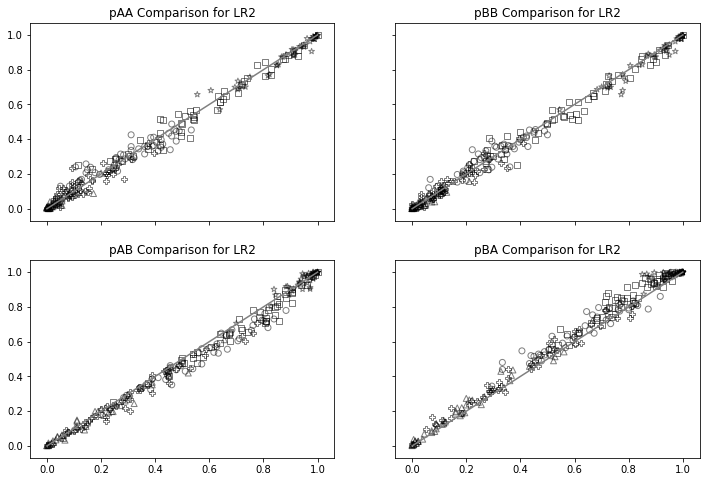

In [465]:
model_name = 'lr2'
num_ratings = 5
num_blocks = 10

types = ['AA', 'BB', 'AB', 'BA']
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(12, 8))

for t, ax in zip(types, axes.flat):

    files_human = []
    files_human.extend(glob.glob('raw/4/*.mat'))
    files_human.extend(glob.glob('raw/8/*.mat'))
    files_human.sort()

    files_model = []
    files_model.extend(glob.glob(f'models/{model_name}/4deg/*points.csv'))
    files_model.extend(glob.glob(f'models/{model_name}/8deg/*points.csv'))
    files_model.sort(key=lambda x: x.replace('_points', ''))

    types = ['AA', 'BB', 'AB', 'BA']
    markers = ['^', 'P', 'o', 's', '*']
    pXY_human = {i:[] for i in range(1, 6)}
    pXY_model = {i:[] for i in range(1, 6)}

    for f_human, f_model in zip(files_human, files_model):

        dat = loadmat(f_human)
        model_dat = pd.read_csv(f_model, index_col = 0)

        real_ratings = []
        for rating in range(num_ratings):
            tmp_check = np.concatenate([dat[f'p_{x}_{rating+1}Diff'][0] for x in types])
            if np.all(tmp_check == 0) or np.all(tmp_check == 1):
                continue
            if rating > 0 and rating < 5 and all([np.all(dat[f'p_{t}_{rating+1}Diff'][0] == dat[f'p_{t}_{rating}Diff'][0]) for t in types]):
                continue

            pXY_human[rating+1].append(np.mean(dat[f'p_{t}_{rating+1}Diff'][0]))
            real_ratings.append(rating)

        for n, rating in enumerate(real_ratings):
            pXY_model[rating+1].append(np.mean(model_dat[f'p{t}'][num_blocks*n:num_blocks*(n+1)]))

    ax.plot([0, 1], [0, 1], linestyle='-', c='gray')
    for m, pH, pM in zip(markers, pXY_human.values(), pXY_model.values()):
        ax.scatter(pH, pM, edgecolors='black', facecolors='none', marker=m, alpha=0.5)
        ax.set_title(f'p{t} Comparison for {model_name.upper()}')

#fig.savefig('DF2_comparison.png')


# Residual Analysis

### Histogram Plot by Level

(-0.488337, 0.6499014444444446, 0.0, 941.85)

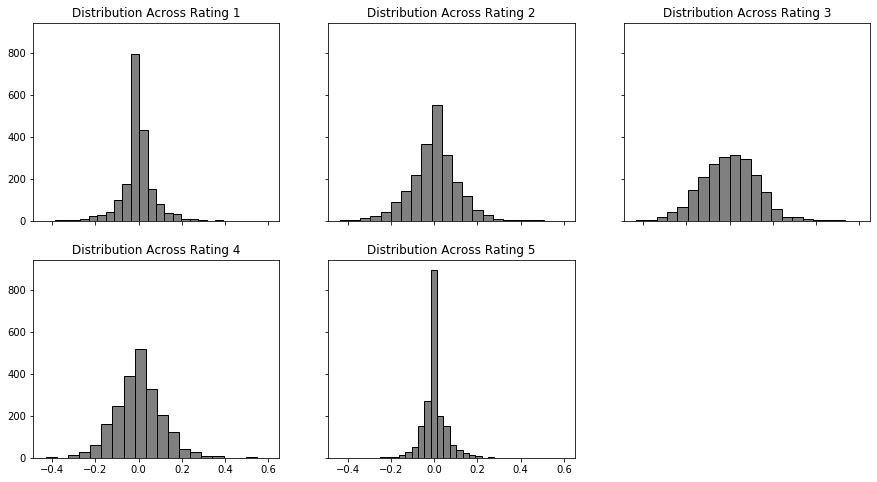

In [560]:
model_name = 'df1'
num_ratings = 5
num_blocks = 10

files_human = []
files_human.extend(glob.glob('raw/4/*.mat'))
files_human.extend(glob.glob('raw/8/*.mat'))

files_model = []
files_model.extend(glob.glob(f'models/{model_name}/4deg/*points.csv'))
files_model.extend(glob.glob(f'models/{model_name}/8deg/*points.csv'))
files_model.sort(key=lambda x: x.replace('_points', ''))

types = ['AA', 'BB', 'AB', 'BA']
pXY_human = {i:[] for i in range(num_ratings)}
pXY_model = {i:[] for i in range(num_ratings)}

for f_human, f_model in zip(files_human, files_model):
    
    dat = loadmat(f_human)
    model_dat = pd.read_csv(f_model, index_col=0)

    n = 0
    for rating in range(num_ratings):
        tmp_check = np.concatenate([dat[f'p_{t}_{rating+1}Diff'][0] for t in types])
        if np.all(tmp_check == 0) or np.all(tmp_check == 1):
            continue
        if rating > 0 and rating < 5 and all([np.all(dat[f'p_{t}_{rating+1}Diff'][0] == dat[f'p_{t}_{rating}Diff'][0]) for t in types]):
            continue

        pXY_human[rating].extend(np.concatenate([dat[f'p_{t}_{rating+1}Diff'][0] for t in types]))
        pXY_model[rating].extend(np.concatenate([model_dat[f'p{t}'][num_blocks*n:num_blocks*(n+1)] for t in types]))
        n += 1

pXY_residuals = {key:np.array(pM) - np.array(pH) for key, (pH, pM) in enumerate(zip(pXY_human.values(), pXY_model.values()))}
'''
fvalue, pvalue = st.f_oneway(*[pXY_residuals[i] for i in d])

print(f'p-value is {round(pvalue, 4)}.')
if pvalue < 0.05:
    print('Null hypothesis rejected. Significant difference between group means.')
else:
    print('Unable to reject null hypothesis.')
'''

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 8))
for i, (vals, ax) in enumerate(zip(pXY_residuals.values(), axes.flat)):
    ax.hist(vals, bins=20, color='gray', ec='black')
    ax.set_title(f'Distribution Across Rating {i+1}')
#axes[-1, -1].text(0.5, 0.5, f'ANOVA p-value: {round(pvalue, 4)}', horizontalalignment='center', verticalalignment='center', transform=axes[-1, -1].transAxes, fontsize=18)
axes[-1, -1].axis('off')

#fig.savefig('DF2_residuals.png')

### RM ANOVA Across Level and pXY

In [556]:
model_name = 'df2'
num_ratings = 5
num_blocks = 10

files_human = []
files_human.extend(glob.glob('raw/4/*.mat'))
files_human.extend(glob.glob('raw/8/*.mat'))

files_model = []
files_model.extend(glob.glob(f'models/{model_name}/4deg/*points.csv'))
files_model.extend(glob.glob(f'models/{model_name}/8deg/*points.csv'))
files_model.sort(key=lambda x: x.replace('_points', ''))

types = ['AA', 'BB', 'AB', 'BA']

df = pd.DataFrame(columns=['Subject', 'pXY', 'Level', 'Residual'])

for f_human, f_model in zip(files_human, files_model):
    
    dat = loadmat(f_human)
    subject = f_human[max(f_human.rfind('/'), f_human.rfind('\\'))+1:f_human.find('.')]
    model_dat = pd.read_csv(f_model, index_col=0)
    
    n = 0
    for rating in range(num_ratings):
        tmp_check = np.concatenate([dat[f'p_{t}_{rating+1}Diff'][0] for t in types])
        if np.all(tmp_check == 0) or np.all(tmp_check == 1):
            continue
        if rating > 0 and rating < 5 and all([np.all(dat[f'p_{t}_{rating+1}Diff'][0] == dat[f'p_{t}_{rating}Diff'][0]) for t in types]):
            continue

        for t in types:
            mean = np.mean(np.array(model_dat[f'p{t}'][num_blocks*n:num_blocks*(n+1)]) - np.array(dat[f'p_{t}_{rating+1}Diff'][0]))
            df.loc[len(df)] = [subject, f'p{t}', rating+1, mean]
        n += 1

res = rm_anova(data=df, dv='Residual', within=['Level', 'pXY'], subject='Subject')
res = res.rename(columns={'ddof1': 'df_num', 'ddof2': 'df_denom'})
print(res)

        Source        SS  df_num  df_denom        MS         F         p-unc  \
0        Level  0.000523       4       212  0.000131  1.898658  1.118517e-01   
1          pXY  0.032497       3       159  0.010832  2.182483  9.220929e-02   
2  Level * pXY  0.050640      12       636  0.004220  5.952059  6.892082e-10   

   p-GG-corr       np2       eps  
0   0.147467  0.034585  0.578777  
1   0.109802  0.039550  0.763624  
2   0.001966  0.100964  0.197218  


### RM ANOVA Across Level and pXY w/ Filtered Subjects

In [552]:
model_name = 'df2'
num_ratings = 5
num_blocks = 10

files_human = []
files_human.extend(glob.glob('raw/4/*.mat'))
files_human.extend(glob.glob('raw/8/*.mat'))

files_model = []
files_model.extend(glob.glob(f'models/{model_name}/4deg/*points.csv'))
files_model.extend(glob.glob(f'models/{model_name}/8deg/*points.csv'))
files_model.sort(key=lambda x: x.replace('_points', ''))

types = ['AA', 'BB', 'AB', 'BA']

df = pd.DataFrame(columns=['Subject', 'pXY', 'Level', 'Residual'])
fit_agg = pd.concat([pd.read_csv(f'results/{model_name[:2]}/{model_name}_8deg.csv', index_col='subject'), 
                     pd.read_csv(f'results/{model_name[:2]}/{model_name}_4deg.csv', index_col='subject')])

for f_human, f_model in zip(files_human, files_model):
    
    dat = loadmat(f_human)
    subject = f_human[max(f_human.rfind('/'), f_human.rfind('\\'))+1:f_human.find('.')]
    model_dat = pd.read_csv(f_model, index_col=0)
    
    if not fit_agg.loc[subject]['explainable']:
        continue
    
    n = 0
    for rating in range(num_ratings):
        tmp_check = np.concatenate([dat[f'p_{t}_{rating+1}Diff'][0] for t in types])
        if np.all(tmp_check == 0) or np.all(tmp_check == 1):
            continue
        if rating > 0 and rating < 5 and all([np.all(dat[f'p_{t}_{rating+1}Diff'][0] == dat[f'p_{t}_{rating}Diff'][0]) for t in types]):
            continue

        for t in types:
            mean = np.mean(np.array(model_dat[f'p{t}'][num_blocks*n:num_blocks*(n+1)]) - np.array(dat[f'p_{t}_{rating+1}Diff'][0]))
            df.loc[len(df)] = [subject, f'p{t}', rating+1, mean]
        n += 1


res = rm_anova(data=df, dv='Residual', within=['Level', 'pXY'], subject='Subject')
res = res.rename(columns={'ddof1': 'df_num', 'ddof2': 'df_denom'})
print(res)

        Source        SS  df_num  df_denom        MS         F         p-unc  \
0        Level  0.000245       4       100  0.000061  0.603041  6.613264e-01   
1          pXY  0.028633       3        75  0.009544  2.950586  3.804748e-02   
2  Level * pXY  0.037654      12       300  0.003138  4.749329  4.064143e-07   

   p-GG-corr       np2       eps  
0   0.560179  0.023553  0.529984  
1   0.062095  0.105564  0.659768  
2   0.013493  0.159645  0.163425  
